<a href="https://colab.research.google.com/github/mahb97/Wake2vec/blob/main/token_injection_and_init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ask and i shall deliver (all the way from london town)

Flume & Chet Faker - Drop the Game

Bearcubs - Touch

Jamie xx- All Under One Roof Raving



In [1]:
!pip -q install transformers==4.43.3 accelerate peft==0.11.1 datasets umap-learn faiss-cpu matplotlib==3.8.4 sentencepiece

import os, re, math, random, json, unicodedata
from pathlib import Path
from collections import Counter
import numpy as np
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
DTYPE = torch.bfloat16 if torch.cuda.is_available() else torch.float32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 8.2 MB/s eta 0:00:00
Device: cuda


In [3]:
tok = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL, torch_dtype=DTYPE, device_map="auto"
)
print("Base vocab size:", tok.vocab_size)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Base vocab size: 32000


In [14]:
try:
    from google.colab import files
    uploaded = files.upload()
    fw_path = list(uploaded.keys())[0]
    raw_text = Path(fw_path).read_text(encoding="utf-8", errors="ignore")
except Exception:
    print("Upload failed or not on Colab, paste instead.")
    raw_text = """
    [PASTE THE FULL TEXT OF FINNEGANS WAKE HERE IF NOT UPLOADING]
    """

s = unicodedata.normalize("NFC", raw_text).replace("\r\n","\n").replace("\r","\n")

# Anchor on 'riverrun' lol
low = s.lower()
start = low.find("riverrun")
if start != -1:
    s = s[start:]
else:
    print("Warning: 'riverrun' not found — header may remain.")

footer_markers = [
    "end of the project gutenberg ebook",
    "*** end of", "distributed proofreaders canada",
    "faded page", "transcriber’s notes", "transcriber's notes",
    "this ebook is made available"
]
low = s.lower()
cut = len(s)
for m in footer_markers:
    idx = low.rfind(m)
    if idx != -1:
        cut = min(cut, idx)
s = s[:cut].strip()

text = s
print("Characters after strip:", len(text))
print("Preview:", text[:200])


Saving FinnegansWake.txt to FinnegansWake (2).txt
Characters after strip: 1364677
Preview: riverrun, past Eve and Adam's, from swerve of shore to bend
of bay, brings us by a commodius vicus of recirculation back to
Howth Castle and Environs.

Sir Tristram, violer d'amores, fr'over the short


In [15]:
added = tok.add_tokens(new_terms, special_tokens=False)
if added != len(new_terms):
    print(f"Note: only {added}/{len(new_terms)} were newly added (collisions or tokenizer rules).")
model.resize_token_embeddings(len(tok))
print("New vocab size:", tok.vocab_size)

New vocab size: 32000


In [ ]:
# add ▁variants + tie lm_head
START = "▁"
prefixed = [START + t for t in new_terms if not t.startswith(START)]
prefixed = [t for t in prefixed if t not in tok.get_vocab()]
added2 = tok.add_tokens(prefixed, special_tokens=False)
model.resize_token_embeddings(len(tok))
print(f"Added {added2} start-of-word variants. Vocab: {tok.vocab_size}")

if model.get_output_embeddings() is not None:
    model.get_output_embeddings().weight = model.get_input_embeddings().weight
    print("Tied lm_head to input embeddings.")


In [17]:
emb = model.get_input_embeddings()

def init_vec(term: str, noise_scale=0.02):
    with torch.no_grad():
        ids = tok(term, add_special_tokens=False)["input_ids"]
        if not ids:
            base = torch.randn_like(emb.weight[0:1])
        else:
            base = emb.weight[ids].mean(dim=0, keepdim=True)
        return (base + noise_scale * torch.randn_like(base)).squeeze(0)

with torch.no_grad():
    for t in new_terms:
        idx = tok.convert_tokens_to_ids(t)
        if idx != tok.unk_token_id:
            emb.weight[idx].copy_(init_vec(t))

print("Initialised", len(new_terms), "embedding rows.")

Initialised 22507 embedding rows.


In [18]:
for p in model.parameters():
    p.requires_grad = False

# Unfreeze input embeddings
model.get_input_embeddings().weight.requires_grad_(True)

# Call my daughter LoRA
USE_LORA = True
if USE_LORA:
    lora_cfg = LoraConfig(
        r=8, lora_alpha=16, lora_dropout=0.05,
        target_modules=["q_proj","k_proj","v_proj","o_proj"],  # TinyLlama on the mound
        bias="none", task_type="CAUSAL_LM"
    )
    model = get_peft_model(model, lora_cfg)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable params:", trainable)

Trainable params: 2252800


In [19]:
# FW
fw_path = None
try:
    from google.colab import files
    uploaded = files.upload()
    fw_path = list(uploaded.keys())[0]
except Exception:
    fw_path = "/content/finnegans_wake.txt"

import re, unicodedata, random
from datasets import Dataset
from transformers import DataCollatorForLanguageModeling

fw = Path(fw_path).read_text(encoding="utf-8", errors="ignore")
fw = unicodedata.normalize("NFC", fw).replace("\r\n","\n").replace("\r","\n")

paras = [p.strip() for p in re.split(r"\n\s*\n", fw) if p.strip()]
probe_terms = {t.lower() for t in new_terms if len(t) <= 40}

hit_idxs = [i for i,p in enumerate(paras) if any(t in p.lower() for t in probe_terms)]

windows = []
RADIUS = 2
for i in hit_idxs:
    start = max(0, i - RADIUS)
    end   = min(len(paras), i + RADIUS + 1)
    windows.append(" ".join(paras[start:end]))

windows = list(dict.fromkeys(windows))
random.shuffle(windows)
if len(windows) < 200:
    windows += random.sample(paras, k=min(2000, len(paras)))

print("Wake-saturated windows:", len(windows))

# Tokenise for LM training
ds = Dataset.from_dict({"text": windows})
def tok_fn(batch):
    return tok(batch["text"], truncation=True, max_length=512)
ds_tok = ds.map(tok_fn, batched=True, remove_columns=["text"])
collator = DataCollatorForLanguageModeling(tokenizer=tok, mlm=False)

Saving FinnegansWake.txt to FinnegansWake (3).txt
Wake-saturated windows: 1633


Map:   0%|          | 0/1633 [00:00<?, ? examples/s]

In [ ]:
args = TrainingArguments(
    output_dir="/content/Wake2vec_adapter",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=5e-4,          # slightly higher: few params are moving
    num_train_epochs=3,
    bf16=torch.cuda.is_available(),
    logging_steps=10,
    save_steps=500,
    save_total_limit=1,
    report_to=[]
)
trainer = Trainer(model=model, args=args, train_dataset=ds_tok, data_collator=collator)
trainer.train()
trainer.save_model("/content/Wake2vec_adapter/final")
tok.save_pretrained("/content/Wake2vec_adapter/final_tok")
print("Saved to /content/Wake2vec_adapter")


Step,Training Loss
10,12.502300
20,10.588000
30,9.589900
40,9.146300
50,9.003400
60,8.876600
70,8.841800
80,8.860400
90,8.776200
100,8.661800


           paùpulation -> ['paùpulation', 'oby', 'TV', 'maggi', '▁TV', 'linux', 'dumnation', 'blackstripe']
           générations -> ['générations', 'signics', '加', 'moggies', 'roner', 'sleep', 'brac', '▁msg']
             introdùce -> ['introdùce', 'flens', '▁enqu', 'len', 'retch', 'megalomane', '▁conte', 'fortnichts']
             fainéants -> ['fainéants', 'angelinas', 'kissier', 'spearhead', 'themodius', 'angler', 'longears', 'synodius']
             tricarême -> ['tricarême', '▁case', 'ex', 'rac', 'dined', 'vić', 'ư', 'üge']
             deathfête -> ['deathfête', 'narked', 'quicklow', '▁stepped', '▁beskrevs', '}_\\', "hidn't", 'Bel']
             grandmère -> ['grandmère', 'frufrocksfull', 'greenislender', 'boildoyle', 'hellsinky', 'Editor', '▁муніципалі', '▁Queen']
             primamère -> ['primamère', '▁paused', 'users', 'gargantast', 'pfuffpfaffing', 'óż', '▁має', 'cutpurse']
              brofèsor -> ['brofèsor', 'occumule', '▁;;', 'soldiering', 'Trans', 'kwhat', 'О', 'fut

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


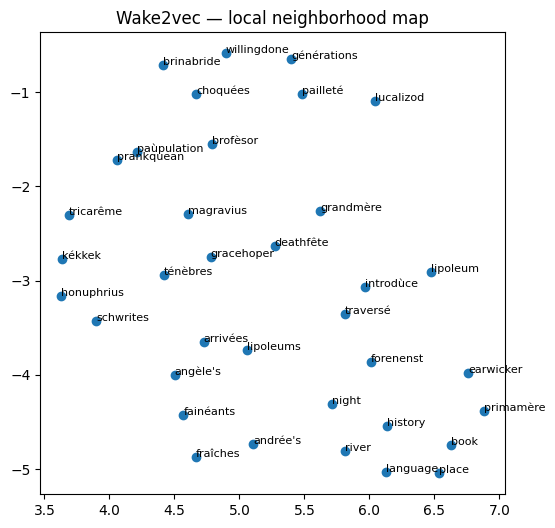


=== By the river, I thought of 
 By the river, I thought of his wake, that woke his wake, of the water and of the ware, the rude of the rude, the rough of the rough, his wake, his w

=== At night, I dream of a 
 At night, I dream of a new place for my old old home. Like a man, they say, but that's not true; I am a man. I am a man. But my feet are the legs of a

=== In the story of this book, 
 In the story of this book, the three were all in the same house, in the house of a sister of the same name, on the same place, in the same street, in the same place. The house of the sister

=== Explain gradient descent in the style of 
 Explain gradient descent in the style of the old man. Explain the process of convection in the style of Mr Gumball. Explain a great deal in the style of Mr Cocks. Explain a lot more


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import umap
import matplotlib.pyplot as plt
import numpy as np

# Nearest neighbors among full vocab
def nearest_neighbors(terms, k=8):
    ids = [tok.convert_tokens_to_ids(t) for t in terms]
    W = emb.weight.detach().cpu().float().numpy() # Convert to float before numpy
    out = {}
    inv = {i:t for t,i in tok.get_vocab().items()}
    for term, idx in zip(terms, ids):
        if idx == tok.unk_token_id:
            continue
        v = W[idx:idx+1]
        sim = cosine_similarity(v, W)[0]
        top = np.argsort(-sim)[:k]
        out[term] = [inv.get(int(j), f"<{j}>") for j in top]
    return out

probe_new = new_terms[:30]
nn = nearest_neighbors(probe_new, k=8)
for k,v in nn.items():
    print(f"{k:>22} -> {v}")

# mix new tokens and some anchors
anchors = ["river","history","book","dream","night","language","think","place","irish","dublin"]
mix = list(dict.fromkeys((probe_new[:40] + anchors)))  # dedupe, preserve order
mix_ids = [tok.convert_tokens_to_ids(t) for t in mix if tok.convert_tokens_to_ids(t) != tok.unk_token_id]
mix_vecs = emb.weight[mix_ids].detach().cpu().float().numpy() # Convert to float before numpy

mapper = umap.UMAP(n_neighbors=8, min_dist=0.1, metric="cosine", random_state=SEED)
xy = mapper.fit_transform(mix_vecs)
plt.figure(figsize=(6,6))
plt.scatter(xy[:,0], xy[:,1])
inv = {i:t for t,i in tok.get_vocab().items()}
for pid, (x,y) in zip(mix_ids, xy):
    plt.text(x, y, inv.get(int(pid), "?"), fontsize=8)
plt.title("Wake2vec — local neighborhood map (FW corpus)")
plt.show()

# Intrusion-style completions
def complete(prompt, max_new_tokens=40):
    inputs = tok(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=True, temperature=0.9, top_p=0.92)
    return tok.decode(out[0], skip_special_tokens=True)

tests = [
    "By the river, I thought of",
    "At night, I dream of a",
    "In the story of this book,",
    "Explain gradient descent in the style of"
]
for p in tests:
    out = complete(p)
    print("\n===", p, "\n", out)

In [ ]:
save_dir = Path("/content/Wake2vec_adapter/minipack")
save_dir.mkdir(parents=True, exist_ok=True)

changed_ids = [tok.convert_tokens_to_ids(t) for t in new_terms if tok.convert_tokens_to_ids(t) != tok.unk_token_id]
emb_slice = emb.weight[changed_ids].detach().cpu().numpy()

np.save(save_dir / "new_token_ids.npy", np.array(changed_ids, dtype=np.int32))
np.save(save_dir / "new_token_vectors.npy", emb_slice)

(Path(save_dir / "README.txt").write_text(
    "Mini adapter: rows from the input embedding matrix for Wake2vec tokens.\n"
    "Apply by loading the base model, then assigning these rows by index\n"
    "into model.get_input_embeddings().weight.\n",
    encoding="utf-8"
))
print("Wrote minimal embedding rows to:", save_dir)


work in progress plus im broke i wann see u try